Los datos son del año 2002 al 2022, pero debemos escojer los del 2000 al 2008

In [124]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

In [123]:
import rasterio
import rasterio.plot as rioplot

In [122]:
import datetime
from pyproj import CRS
import xarray as xr
import rioxarray
import regionmask as rm

In [125]:
datos_ruta = Path("~/shared/proyecto5")

In [126]:
ecoregiones_gdf = gpd.read_file(datos_ruta / "MEOW" / "meow_ecos.shp")

Seleccionamos la ecoregio 

In [127]:
def seleccion_ecoregion(gdf, ecoregion):
    sel_gdf = gdf[gdf["ECOREGION"] == ecoregion]
    sel_bordes_df = sel_gdf.geometry.bounds
    sel_bordes = dict(
        minx=sel_bordes_df.minx.values[0],
        maxx=sel_bordes_df.maxx.values[0],
        miny=sel_bordes_df.miny.values[0],
        maxy=sel_bordes_df.maxy.values[0],
    )
    return sel_gdf, sel_bordes

In [128]:
ecoregion_gdf, ecoregion_bordes = seleccion_ecoregion(ecoregiones_gdf, "Central Chile")

In [129]:
ecoregion_bordes

{'minx': -75.10540619974876,
 'maxx': -67.10354480343818,
 'miny': -33.305645619864436,
 'maxy': -25.021829486895513}

Leer los datos ERDDAP

In [151]:
erddap_opendap_url = 'https://coastwatch.pfeg.noaa.gov/erddap/es/griddap/erdMH1sstdmdayR20190SQ'

fuente_ds = xr.open_dataset(erddap_opendap_url)

In [152]:
fuente_ds

<xarray.Dataset>
Dimensions:    (time: 226, latitude: 4320, longitude: 8640)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-16 ... 2021-10-16
  * latitude   (latitude) float64 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * longitude  (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    sstMasked  (time, latitude, longitude) float32 ...
Attributes: (12/36)
    acknowledgement:           NASA GSFC
    cdm_data_type:             Grid
    contact:                   https://www.pfeg.noaa.gov/guest_book.html
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creation_date:             2021-12-24 10:53:33.698319
    creator_email:             erd.data@noaa.gov
    ...                        ...
    summary:                   This is the delayed, science-quality, monthly ...
    testOutOfDate:             now-120days
    time_coverage_end:         2021-10-16T00:00:00Z
    time_coverage_start:       2003-01-16T00:00:00Z
    title:                     SST, AQUA_MODIS, L3m.MO.SST.sst.4km, Masked, S...
    Westernmost_Easting:       -179.9792

In [153]:
print(f"Tamaño del dataset: {subset_fuente_ds.nbytes/1e6} MB")

Tamaño del dataset: 0.0002 MB


print(f"Tamaño del dataset: {fuente_ds.nbytes}")

print(f"Tamaño del dataset: {fuente_ds.nbytes/1e6}MB")

Definir subset del dataset de SST

In [154]:
año_inicio = 2014
año_final= 2015

In [155]:
subset_fuente_ds = fuente_ds.sel(
    time=slice(datetime.datetime(año_inicio,1,1), datetime.datetime(año_final,12,31)), 
    latitude=slice(ecoregion_bordes['maxy'], ecoregion_bordes['miny']),
    longitude=slice(ecoregion_bordes['minx'], ecoregion_bordes['maxx'])
)

In [156]:
subset_fuente_ds

<xarray.Dataset>
Dimensions:    (time: 24, latitude: 198, longitude: 193)
Coordinates:
  * time       (time) datetime64[ns] 2014-01-16 ... 2015-12-16
  * latitude   (latitude) float64 -25.06 -25.1 -25.15 ... -33.19 -33.23 -33.27
  * longitude  (longitude) float64 -75.1 -75.06 -75.02 ... -67.19 -67.15 -67.1
Data variables:
    sstMasked  (time, latitude, longitude) float32 ...
Attributes: (12/36)
    acknowledgement:           NASA GSFC
    cdm_data_type:             Grid
    contact:                   https://www.pfeg.noaa.gov/guest_book.html
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creation_date:             2021-12-24 10:53:33.698319
    creator_email:             erd.data@noaa.gov
    ...                        ...
    summary:                   This is the delayed, science-quality, monthly ...
    testOutOfDate:             now-120days
    time_coverage_end:         2021-10-16T00:00:00Z
    time_coverage_start:       2003-01-16T00:00:00Z
    title:                     SST, AQUA_MODIS, L3m.MO.SST.sst.4km, Masked, S...
    Westernmost_Easting:       -179.9792

In [157]:
print(f"Tamaño del dataset: {subset_fuente_ds.nbytes/1e6} MB")

Tamaño del dataset: 3.671864 MB


Descargar los datos al dataset de xarray

In [158]:
%%time
subset_fuente_ds.load();

CPU times: user 95 ms, sys: 55.8 ms, total: 151 ms
Wall time: 1min 7s


Exploramos los datos 

In [159]:
subset_fuente_ds

<xarray.Dataset>
Dimensions:    (time: 24, latitude: 198, longitude: 193)
Coordinates:
  * time       (time) datetime64[ns] 2014-01-16 ... 2015-12-16
  * latitude   (latitude) float64 -25.06 -25.1 -25.15 ... -33.19 -33.23 -33.27
  * longitude  (longitude) float64 -75.1 -75.06 -75.02 ... -67.19 -67.15 -67.1
Data variables:
    sstMasked  (time, latitude, longitude) float32 20.65 20.69 20.6 ... nan nan
Attributes: (12/36)
    acknowledgement:           NASA GSFC
    cdm_data_type:             Grid
    contact:                   https://www.pfeg.noaa.gov/guest_book.html
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creation_date:             2021-12-24 10:53:33.698319
    creator_email:             erd.data@noaa.gov
    ...                        ...
    summary:                   This is the delayed, science-quality, monthly ...
    testOutOfDate:             now-120days
    time_coverage_end:         2021-10-16T00:00:00Z
    time_coverage_start:       2003-01-16T00:00:00Z
    title:                     SST, AQUA_MODIS, L3m.MO.SST.sst.4km, Masked, S...
    Westernmost_Easting:       -179.9792

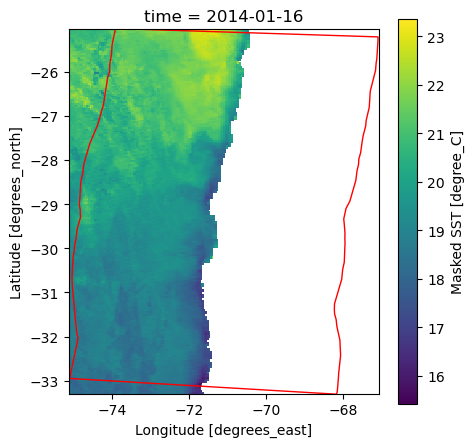

In [160]:
_, ax = plt.subplots(ncols=1, figsize=(5,5))
subset_fuente_ds.sstMasked.isel(time=0).plot(ax=ax)
ecoregion_gdf.plot(ax=ax, edgecolor='red', facecolor='none');

In [161]:
sst_xypromedio_df = subset_fuente_ds.sstMasked.mean(dim=('latitude', 'longitude'))

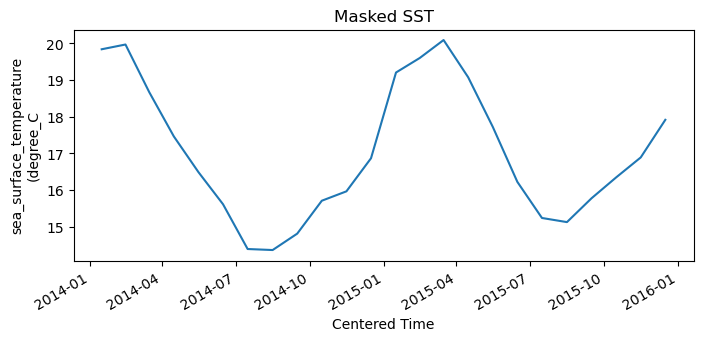

In [162]:
da = subset_fuente_ds.sstMasked

sst_xypromedio_df.plot(figsize=(8,3))
plt.ylabel(f"{da.standard_name}\n({da.units}")
plt.title(da.long_name);